# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from ObservPredictor import * #ProcessObservationalDataset, ObsParameterPredictor
from DeepRegTrainer import TrainRegression
from StatVisAnalyzer import *

2023-07-21 13:29:11.010205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

In [2]:
# Import functions from other modules ============================
from io_funs import LoadSave

# Import python libraries ========================================
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

from tensorflow.keras.models import save_model
import pickle as pk

# Import BOHB Package ========================================

# Libraries for BOHB Package 
import logging
logging.basicConfig(level=logging.WARNING)

import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import MyWorker

from tensorflow.keras.models import load_model
import ConfigSpace as CS
from hpbandster.core.worker import Worker

import logging
logging.basicConfig(level=logging.WARNING)

import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import MyWorker

from tensorflow.keras.models import load_model





import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Conv1D, Concatenate, Dense, MaxPooling1D
from tensorflow.keras.models import Model

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K
    
# mlp for multi-output regression
from numpy import mean
from numpy import std
from keras.models import Sequential
from keras.layers import Dense

import warnings
import logging

# Step 1: Load the dataset

In [3]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [4]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [5]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [6]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [7]:
y['temperature'] = np.log10(y['temperature'])

/tmp/ipykernel_55778/3354840019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['temperature'] = np.log10(y['temperature'])


In [8]:
# print( 'skewness:' )
# display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
# y.hist(grid=True, bins=19);

In [9]:
y.head(5)

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [10]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [11]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [12]:
# normalize the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

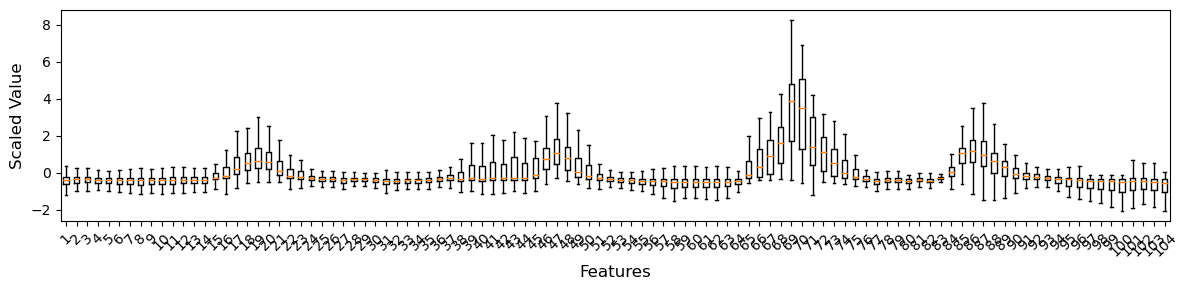

In [13]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_standardized_rowwise, xticks_list = None)

In [14]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

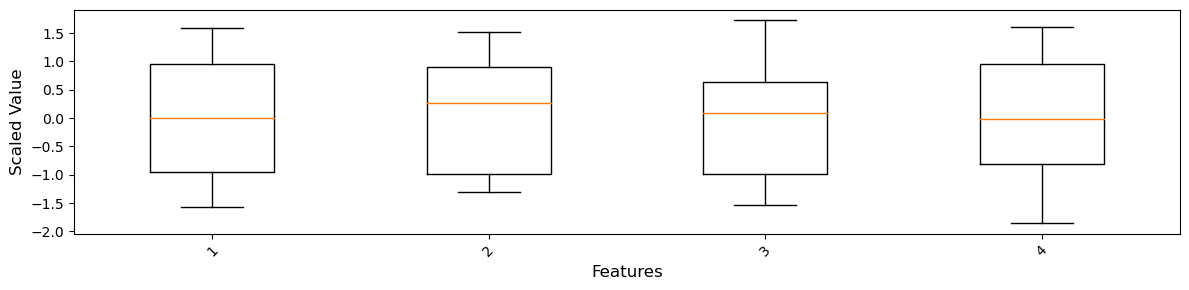

In [15]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [16]:
# train_cnn_regression.y_train_standardized_columnwise

In [17]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [18]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [19]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [20]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [21]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [22]:
df_MinMax_train.head()

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06


In [23]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [24]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

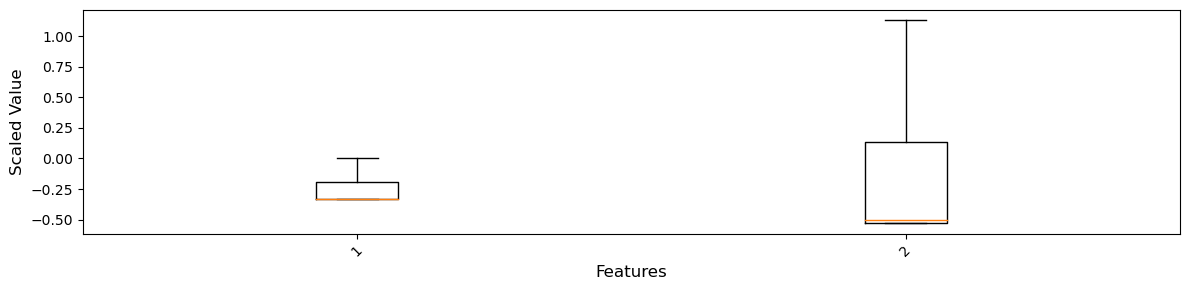

In [25]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Train CNN model

In [26]:


class KerasWorker(Worker):
    def __init__(self, 
                   X1_train, X1_val, X1_test, # Row-StandardScaled input spectra
                   X2_train, X2_val, X2_test, # Col-StandardScaled Mix Max of all rows of input spetra
                   y1_train, y1_val, y1_test, # Col-StandardScaled target feature 1
                   y2_train, y2_val, y2_test, # Col-StandardScaled target feature 2
                   y3_train, y3_val, y3_test, # Col-StandardScaled target feature 3
                   y4_train, y4_val, y4_test, # Col-StandardScaled target feature 4                 
                   *args, sleep_interval=0, **kwargs):

            super().__init__(**kwargs)
            self.sleep_interval = sleep_interval

            # self.batch_size = 2**9


            # train, val, test sets for input 1 (main 104 spectral features)
            self.X1_train, self.X1_val, self.X1_test = X1_train, X1_val, X1_test

            # train, val, test sets for input 2 (Min and Max 2 features)
            self.X2_train, self.X2_val, self.X2_test = X2_train, X2_val, X2_test
            
            # train, val, test sets for target features            
            self.y1_train, self.y1_val, self.y1_test = y1_train, y1_val, y1_test
            self.y2_train, self.y2_val, self.y2_test = y2_train, y2_val, y2_test
            self.y3_train, self.y3_val, self.y3_test = y3_train, y3_val, y3_test 
            self.y4_train, self.y4_val, self.y4_test = y4_train, y4_val, y4_test   


            # self.input_shape = (104,1)
            # print(np.shape(self.x_train), np.shape(self.y_train))


    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        Convolution Neural Networks to be optimized by BOHB package.
        The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
        """
                        
        Conv__filters = config['Conv__filters']
        Conv__kernel_size = config['Conv__kernel_size']
        Conv__MaxPooling1D = config['Conv__MaxPooling1D']
        Conv__NumberLayers = config['Conv__NumberLayers']
        Conv__NumberBlocks = config['Conv__NumberBlocks']

        FC__units = config['FC__units']
        FC__units_temperature = config['FC__units_temperature']
        FC__units_c_o_ratio = config['FC__units_c_o_ratio']
        FC__units_gravity = config['FC__units_gravity']
        FC__units_metallicity = config['FC__units_metallicity']
        FC__NumberLayers = config['FC__NumberLayers']
        
        FC__dropout = config['FC__dropout']
        
        FC_out_dropout = config['FC_out_dropout']

        FC_in_Conv__units = config['FC_in_Conv__units']
        FC_in_Conv__dropout = config['FC_in_Conv__dropout']
        FC_in_Conv__NumberLayers = config['FC_in_Conv__NumberLayers']
        

        lr = config['lr']

        

        ######### Shape of the inputs
        input_1 = tf.keras.layers.Input(shape=(104, 1))
        input_2 = tf.keras.layers.Input(shape=(2,))

        
        ######### Conv Blocks  ####################################
        model = input_1
        for b in range(0, Conv__NumberBlocks):
            for l in range(0, Conv__NumberLayers):
                model = Conv1D(filters = Conv__filters*(b+l+1)**2, 
                                  kernel_size = Conv__kernel_size, 
                                  strides = 1, 
                                  padding ='same', 
                                   activation = 'relu',
                                  kernel_initializer = 'he_normal',
                                  # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                                  name = 'Conv__B'+str(b+1)+'_L'+str(l+1))(model) #(model if l != 0 and b != 0 else input_1)

            model = MaxPooling1D(pool_size=(Conv__MaxPooling1D),
                                name = 'MaxPooling1D__B'+str(b+1)+'_L'+str(l+1))(model)

        ######### Flatten Layer   ####################################
        model = Flatten()(model)


        ######### FC Layer before the Concatenation   ################
        for l in range(FC_in_Conv__NumberLayers):
            model = Dense(FC_in_Conv__units*(l+1)**2,
                               activation = 'relu',
                               kernel_initializer = 'he_normal',
                               # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                               name = 'FC_in_Conv__B'+str(b+1)+'_L'+str(l+1))(model)

            model= Dropout(FC__dropout,
                            name = 'FC_in_Conv__Dropout__B'+str(1)+'_L'+str(l+1))(model)


        ######### Concatenation Layer  ###############################
        # Concatenate the outputs from the convolutional layers and dense layer
        model = tf.keras.layers.concatenate([model, input_2], 
                                                           name='Concatenated_Layer')

        ######### FC Block  ####################################
        for l in range(FC__NumberLayers):
            model = Dense(FC__units*(l+1)**2,
                               activation = 'relu',
                       kernel_initializer = 'he_normal',
                       # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                       name = 'FC__B'+str(b+1)+'_L'+str(l+1))(model)

            model= Dropout(FC__dropout,
                                   name = 'FC__Dropout__B'+str(1)+'_L'+str(l+1))(model)

        ######### 3rd FC Block: gravity  ##############################

        model2 = Dense(FC__units_gravity, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_gravity')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_gravity__Dropout')(model2)
        
        out__gravity = Dense(1, 
                             activation = 'linear',
                             kernel_initializer = 'he_normal',
                             name = 'gravity')(model2)
        

        
        ######### 3rd FC Block: c_o_ratio  ##############################
        model2 = Dense(FC__units_c_o_ratio, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_c_o_ratio')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_c_o_ratio__Dropout')(model2)


        out__c_o_ratio = Dense(1, 
                               activation = 'linear',
                               # kernel_initializer = 'he_normal',
                               # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                               name='c_o_ratio')(model2)

        
        ######### 3rd FC Block: metallicity  ##############################
        model2 = Dense(FC__units_metallicity, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_metallicity')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_metallicity__Dropout')(model2)

        
        out__metallicity = Dense(1, 
                                 activation = 'linear',
                                 # kernel_initializer = 'he_normal',
                                 name='metallicity')(model2)
        
        
        
        ######### 3rd FC Block: temperature  ##############################
        model2 = Dense(FC__units_temperature, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_temperature')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_temperature__Dropout')(model2)
        

        out__temperature = Dense(1, 
                                 activation = 'linear',
                                 name='temperature')(model2)


        ######### OUTPUT   ################################################
        # Create the model with two inputs and two outputs
        model = tf.keras.Model(inputs=[input_1, input_2], 
                               outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])

        # Compile the model with an optimizer, loss function, and metrics
        model.compile(loss='huber_loss', 
                      optimizer=keras.optimizers.Adam(lr = lr),  
                      metrics=['mae'])
        
        
        
 

  
        early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                                       restore_best_weights=True)



        # YOU CAN ADD FUNCTION HERE TO ADD NOISE
        history = model.fit(x = [self.X1_train, self.X2_train], 
                            y = [self.y1_train, self.y2_train, self.y3_train, self.y4_train],  #self.x_train, self.y_train,
                          batch_size = 32, #config['batch_size'], # self.batch_size,
                          validation_data=([self.X1_val, self.X2_val], [self.y1_val, self.y2_val, self.y3_val, self.y4_val]),
                          #validation_split=0.2,
                          epochs=int(budget),
                          verbose=1,
                          callbacks=[early_stop],
                 )


        train_score = model.evaluate(x = [self.X1_train, self.X2_train], 
                                     y = [self.y1_train, self.y2_train, self.y3_train, self.y4_train],
                                     verbose=0)
        val_score   = model.evaluate(x = [self.X1_val, self.X2_val], 
                                     y = [self.y1_val, self.y2_val, self.y3_val, self.y4_val],
                                     verbose=0)
        test_score  = model.evaluate(x = [self.X1_test, self.X2_test], 
                                     y = [self.y1_test, self.y2_test, self.y3_test, self.y4_test],
                                     verbose=0)

        #print(train_score, val_score, test_score)
#             #import IPython; IPython.embed()
        return ({
                'loss': val_score[0], # remember: HpBandSter always minimizes!
                'info': {       'test accuracy': test_score,
                                        'train accuracy': train_score,
                                        'validation accuracy': val_score,
                                        'number of parameters': model.count_params(),
                                },
                'model' : model,
                'history' : history,

        })


In [27]:
w = KerasWorker(
            # input dataset: StandardScaled instances  
            X1_train = train_cnn_regression.X_train_standardized_rowwise,
            X1_val   = train_cnn_regression.X_val_standardized_rowwise,
            X1_test  = train_cnn_regression.X_test_standardized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = train_cnn_regression.X_train_standardized_columnwise,
            X2_val   = train_cnn_regression.X_val_standardized_columnwise,
            X2_test  = train_cnn_regression.X_test_standardized_columnwise,

            # 1st target
            y1_train = train_cnn_regression.y_train_standardized_columnwise[:,0],
            y1_val   = train_cnn_regression.y_val_standardized_columnwise[:,0],
            y1_test  = train_cnn_regression.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = train_cnn_regression.y_train_standardized_columnwise[:,1],
            y2_val   = train_cnn_regression.y_val_standardized_columnwise[:,1],
            y2_test  = train_cnn_regression.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = train_cnn_regression.y_train_standardized_columnwise[:,2],
            y3_val   = train_cnn_regression.y_val_standardized_columnwise[:,2],
            y3_test  = train_cnn_regression.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = train_cnn_regression.y_train_standardized_columnwise[:,3],
            y4_val   = train_cnn_regression.y_val_standardized_columnwise[:,3],
            y4_test  = train_cnn_regression.y_test_standardized_columnwise[:,3],



            sleep_interval = 0.5, 
            # nameserver=ip_address,
            run_id='CNNtrain')

In [28]:
config =  {'Conv__MaxPooling1D': 2,
         'Conv__NumberBlocks': 1,
         'Conv__NumberLayers': 3,
         'Conv__filters': 4,
         'Conv__kernel_size': 6,
         'FC__NumberLayers': 4,
         'FC__dropout': 0.0024609140719442646,
         'FC__units': 64,
         'FC__units_c_o_ratio': 64,
         'FC__units_gravity': 16,
         'FC__units_metallicity': 256,
         'FC__units_temperature': 8,
         'FC_in_Conv__NumberLayers': 4,
         'FC_in_Conv__dropout': 0.09889223768186726,
         'FC_in_Conv__units': 128,
         'FC_out_dropout': 0.002185843015008406,
         'lr': 4.9946842008422193e-05}

In [ ]:
# cs = worker.get_configspace()

# cs = get_configspace2()

# config = cs.sample_configuration().get_dictionary()
display(config)

trained_cnn_model = w.compute(config = config, budget = 200, working_directory='../../outputs/trained_models/')

{'Conv__MaxPooling1D': 2,
 'Conv__NumberBlocks': 1,
 'Conv__NumberLayers': 3,
 'Conv__filters': 4,
 'Conv__kernel_size': 6,
 'FC__NumberLayers': 4,
 'FC__dropout': 0.0024609140719442646,
 'FC__units': 64,
 'FC__units_c_o_ratio': 64,
 'FC__units_gravity': 16,
 'FC__units_metallicity': 256,
 'FC__units_temperature': 8,
 'FC_in_Conv__NumberLayers': 4,
 'FC_in_Conv__dropout': 0.09889223768186726,
 'FC_in_Conv__units': 128,
 'FC_out_dropout': 0.002185843015008406,
 'lr': 4.9946842008422193e-05}

2023-07-21 13:29:36.015113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 13:29:36.021006: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/egharibn/anaconda3/envs/bohb/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
 10/782 [..............................] - ETA: 22:52 - loss: 1.9127 - gravity_loss: 0.6490 - c_o_ratio_loss: 0.5769 - metallicity_loss: 0.3945 - temperature_loss: 0.2924 - gravity_mae: 1.0665 - c_o_ratio_mae: 0.9833 - metallicity_mae: 0.7725 - temperature_mae: 0.6068

In [ ]:
# history

In [ ]:
trained_cnn_model

In [ ]:
train_cnn_regression.trained_model = trained_cnn_model['model']
train_cnn_regression.trained_model_history = trained_cnn_model['history']

## Save Trained Model

In [ ]:
train_cnn_regression.trained_model.save('../../outputs/trained_models/trained_CNN_architecture_BOHB_parameters_v3.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/trained_models/trained_CNN_weights_BOHB_parameters_v3.h5')

with open('../../outputs/trained_models/trained_CNN_history_BOHB_parameters_v3.pkl', 'wb') as file:
    pk.dump(train_cnn_regression.trained_model_history, file)
    


## Load Saved Models

In [ ]:
# model = load_model('../../outputs/regression/trained_models/my_model_architecture__xStand_yStand_MinMax_v2.h5')
# model.load_weights('../../outputs/regression/trained_models/my_model_weights__xStand_yStand_MinMax_v2.h5')

# # Loading the saved history object
# with open('../../outputs/regression/trained_models/training_history__xStand_yStand_MinMax_v2.pkl', 'rb') as file:
#     history = pk.load(file)    

In [ ]:
model = load_model('../../outputs/trained_models/trained_CNN_architecture_BOHB_parameters_v2.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_BOHB_parameters_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_BOHB_parameters_v2.pkl', 'rb') as file:
    history = pk.load(file)    

In [ ]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 4: Check Trained Model

---

In [ ]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [ ]:
train_cnn_regression.trained_model.summary()

In [ ]:
train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot Y predicted vs Y_Actual: Histogram & Scatter plot

In [ ]:
i = 19
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )